# Mood-RL Model Fitting
## Section 1: Motivating model parameterization  
### Explaining the "Matt trick"
To fit reinforcement learning models with Stan, we utilize non-centered parameterizations (aka the "Matt trick"). This parameterization improves the efficiency of MCMC sampling by making the sampling space uniformly dense. Traditionally in Bayesian modeling, the inverse temperature ($\beta$) and learning rate ($\eta$) are sampled from directly (often with non-informative uniform priors). We will instead employ a two-step procedure where we will first sample from independent unit normal priors and then transform the samples into their appropriate parameter spaces:

> $\beta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta = C \cdot \text{Phi_approx}(\beta_{pr})$

> $\eta_{pr} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta = \text{Phi_approx}(\eta_{pr}) $

where *Phi_approx* is a fast approximation of the cumulative unit normal [(Bowling et al., 2009)](http://www.jiem.org/index.php/jiem/article/view/60):

> $\text{Phi_approx}(x) = \text{logit}^{-1}(0.07056 \ x^3 + 1.5976 \ x) $

As an approximation of the cumulative unit normal, the *Phi_approx* function conveniently scales its inputs to be in the range $x \in (0, 1)$. As such, samples from $\eta_{pr}$ are of appropriate scale following transformation. Because values of $\beta$ are normally much larger than 1, a scaling function, $C$, is used to scale the samples of $\beta_{pr}$ to an appropriate range. For example, a user would set $C=20$ to sample $\beta \in (0,20)$.

For details, see the [Stan users manual](http://mc-stan.org/users/documentation/) (section 28.6). The [*hBayesDM*](https://github.com/CCS-Lab/hBayesDM) and [*fitr*](https://github.com/abrahamnunes/fitr) packages provided the templates for fitting these models.

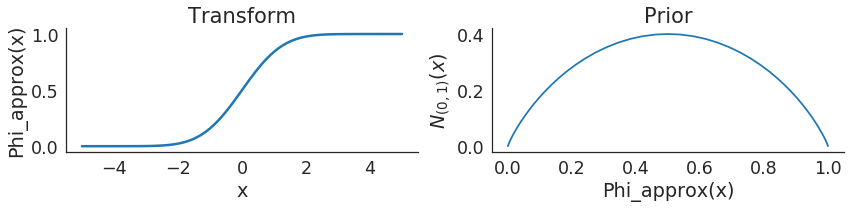

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import norm
from scripts.utilities import phi_approx
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,3))
x = np.linspace(-5,5,101)

## Plot Phi_approx function.
axes[0].plot(x, phi_approx(x), lw=2.5)
axes[0].set(xlabel='x', ylabel='Phi_approx(x)', title='Transform')

## Plot prior.
axes[1].plot(phi_approx(x), norm(0,1).pdf(x))
axes[1].set(xlabel='Phi_approx(x)', ylabel=r'$N_{(0,1)}(x)$', title='Prior')

sns.despine()
plt.tight_layout()

**Figure 1:** Visualizing the *Phi_approx* function. (Left) The transformation of arbitrary values, $x$, through *Phi_approx*. (Right) The probability density of *Phi_approx* scaled values, $x$, sampled from a unit normal distribution.

### Hierarchical parameterization
Non-centered parameterizations are especially useful for hierarchical models, where parameters may vary dramatically in scale (resulting in sampling issues). As such, all subject parameters are similarly sampled from a unit normal prior and transformed. To make the model hierarchical, i.e. to enforce partial pooling, subject-level parameters ($\beta_i, \eta_i$) are estimated using a similar two-step procedure:

> $\beta_{pr, i} \ \text{~} \mathcal{N}(0,1) $ 

> $\beta_i = C \cdot \text{Phi_approx}(\beta_{pr,\mu} + \sigma_{\beta} \cdot \beta_{pr,i})$

> $\eta_{pr,i} \ \text{~} \mathcal{N}(0,1) $ 

> $\eta_i = \text{Phi_approx}(\eta_{pr,\mu} + \sigma_{\eta} \cdot \eta_{pr,i}) $

where $\beta_{pr,\mu}$ and $\eta_{pr,\mu}$ are the group-level inverse temperature and learning rates, respectively; and $\sigma$ captures the variance of the subject-level parameters around the group mean. As above, the group-level parameters are also sampled through a unit normal prior. The variances can be sampled through a half-cauchy distribution or gamma distribution.  

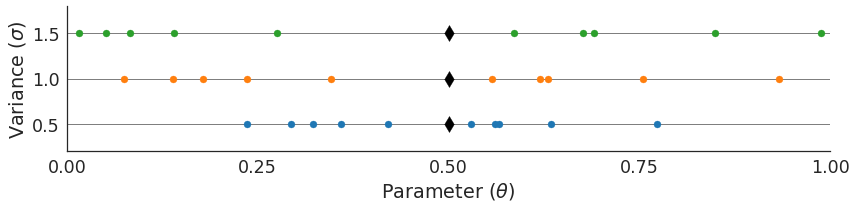

In [2]:
## Randomly generate arbitrary subject-level parameters.
np.random.seed(47404)
theta = np.random.normal(0,1,10)
sigma = [0.5,1,1.5]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
for s in sigma:
    ax.scatter(phi_approx(0 + s * theta), np.ones_like(theta)*s)
ax.scatter(phi_approx(np.zeros(3)), [0.5,1,1.5], s=130, marker='d', color='k')
    
## Add info.
ax.hlines(sigma, 0, 1, lw=0.5, zorder=0)
ax.set(xlim=(0,1), xticks=np.linspace(0,1,5), xlabel=r'Parameter ($\theta$)', 
       ylim=(0.2, 1.8), yticks=sigma, ylabel=r'Variance ($\sigma$)')
    
sns.despine()
plt.tight_layout()

**Figure 2:** Visualizing the hierarchical model. Arbitrarily sampled subject-level variables, $\theta_i$ (color circles), are distributed around a group-level variable, $\theta_\mu$ (diamonds). The variance of their distribution is dictated by $\sigma$. When $\sigma < 1$, the subject-level parameters shrink towards group-level value; when $\sigma > 1$, the subject-level parameters move away from group-level value.

### Prior on the mood-bias parameter ($f$) 

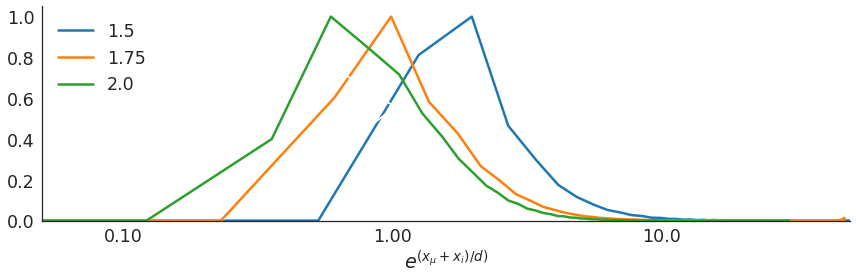

In [3]:
np.random.seed(47404)

## Simulate data.
f_pr = np.random.multivariate_normal(np.zeros(2), np.identity(2), int(1e6))
divisor = [1.5, 1.75, 2.0]

fig, ax = plt.subplots(1,1,figsize=(12,4))
for d in divisor:
    
    ## Compute f (assumings sigma = 1).
    f = np.exp( np.sum(f_pr, axis=1) / d )
    
    ## Plot.
    sns.kdeplot(f, color='w', ax=ax)
    line = ax.lines[-1]
    xdata, ydata = line.get_xdata(), line.get_ydata()
    ax.plot(xdata, ydata/ydata.max(), lw=2.5, label=d)
    
ax.set_xscale('log')
ax.set(xlim=(0.05, 50), xticks=np.logspace(-1,2,4), xlabel=r'$e^{(x_\mu + x_i)/d)}$', 
       ylim=(0,1.05), xticklabels=['0.10','1.00','10.0','100.'])
ax.legend(loc=2)
sns.despine()
plt.tight_layout()

## Section 2: Model fitting

In [4]:
import os, pystan
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = False

## Sampling parameters.
samples = 1250
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()
dt = data.Datetime.unique()

## Extract and prepare task data.
X = data[['M1','M2']].values.reshape(N,B,T,2)
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )
R = data.Outcome.values.reshape(N,B,T)
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

h12 = ratings.loc[ratings.Trial==0, 'Rating'].values.reshape(N,2) / 4
h12 = np.where(h12==-1, -0.99, np.where(h12==1, 0.99, h12))
h12 = np.arctanh(h12)

## Extract and prepare WoF data.
WoF = np.sign(metadata.WoF.values) * 28

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, R=R, M=M, h12=h12, WoF=WoF)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Define control parameters.
    if 'orig' in model_name: control = dict(adapt_delta = 0.9)
    else: control = None
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, 
                      chains=chains, control=control, n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as f: cPickle.dump(extract, f)
        
    print('Done.')

<IPython.core.display.Javascript object>

## Model Comparisons
### No-pooling vs. partial-pooling

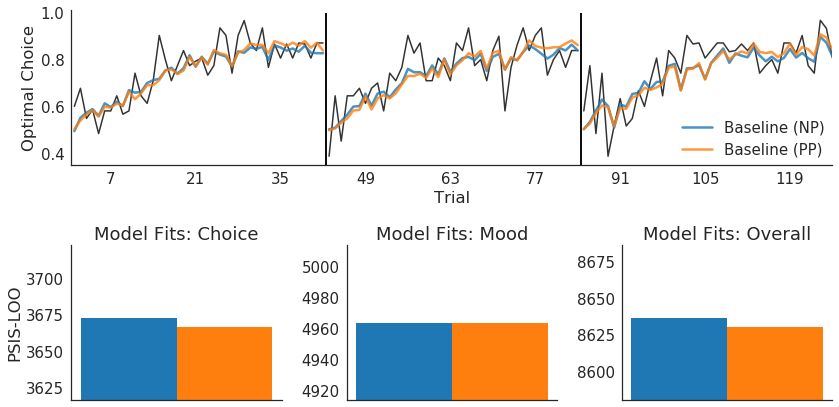

In [5]:
from scripts.plotting import plot_group_comparison
from scripts.utilities import psis_model_comparison

## Define Stan models.
model_names = ['moodRL_npool_base', 'moodRL_ppool_base']

## Plot models.
plot_group_comparison(model_names, ['Baseline (NP)','Baseline (PP)'], show_mood=False);

In [6]:
## Compute model comparison.
psis_model_comparison('moodRL_npool_base', 'moodRL_ppool_base');

Model comparison
----------------
PSIS[1] = 8636
PSIS[2] = 8630
Diff	= 5.93 (14.22)


### Mood Models

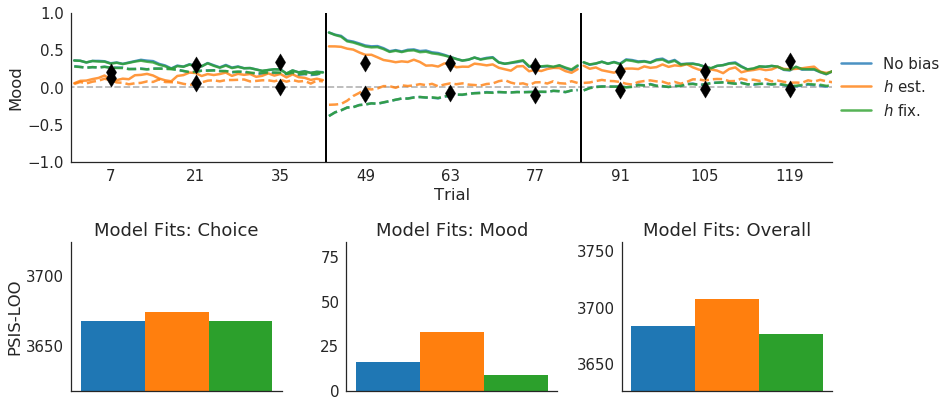

In [7]:
## Define Stan models.
model_names = ['moodRL_ppool_mood', 'moodRL_ppool_mood_bias_orig', 'moodRL_ppool_mood_bias_mod']

## Plot models.
labels = [r'No bias', r'$h$ est.', r'$h$ fix.']
plot_group_comparison(model_names, labels, show_behavior=False);

In [8]:
## Compute model comparison.
psis_model_comparison('moodRL_ppool_mood', 'moodRL_ppool_mood_bias_orig');

Model comparison
----------------
PSIS[1] = 3684
PSIS[2] = 3707
Diff	= -23.75 (31.27)


In [9]:
## Compute model comparison.
psis_model_comparison('moodRL_ppool_mood', 'moodRL_ppool_mood_bias_mod');

Model comparison
----------------
PSIS[1] = 3684
PSIS[2] = 3676
Diff	= 7.33 (5.39)


In [10]:
## Compute model comparison.
psis_model_comparison('moodRL_ppool_mood_bias_orig', 'moodRL_ppool_mood_bias_mod');

Model comparison
----------------
PSIS[1] = 3707
PSIS[2] = 3676
Diff	= 31.09 (30.91)


### Digging deeper

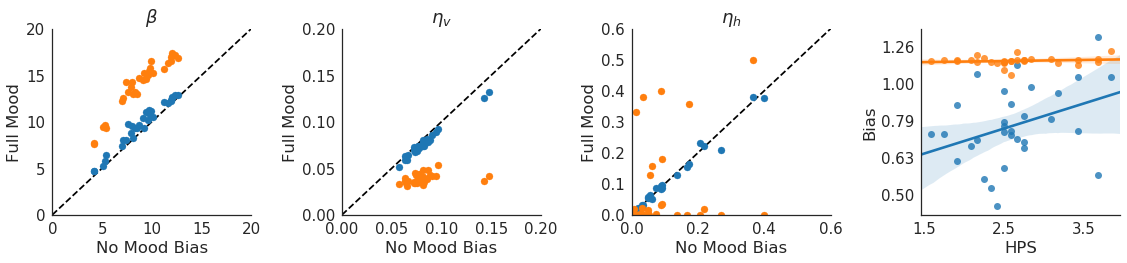

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

 ## Load mood StanFit file.
f = 'stan_fits/moodRL_ppool_mood/StanFit.pickle'
with open(f, 'rb') as f: fit1 = cPickle.load(f)
    
## Load mood bias (mod) StanFit file.
f = 'stan_fits/moodRL_ppool_mood_bias_mod/StanFit.pickle'
with open(f, 'rb') as f: fit2 = cPickle.load(f)
    
## Load mood bias (orig) StanFit file.
f = 'stan_fits/moodRL_ppool_mood_bias_orig/StanFit.pickle'
with open(f, 'rb') as f: fit3 = cPickle.load(f)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(16,4))

for ax, param, lim in zip(axes, ['beta', 'eta_v', 'eta_h'], [(0,20),(0,0.2),(0,0.6)]):
    
    ## Find mode of posterior distribution.
    x = np.median(fit1[param], axis=0)
    y1 = np.median(fit2[param], axis=0)
    y2 = np.median(fit3[param], axis=0)
    
    ## Plot.
    ax.scatter(x, y1)
    ax.scatter(x, y2)
    ax.plot(lim, lim, color='k', linestyle='--', zorder=0)
    ax.set(xlim=lim,xlabel='No Mood Bias', ylim=lim,ylabel='Full Mood', title=r'$\%s$' %param)

## Plot f.
sns.regplot(metadata.IPIP_hps, np.log10(np.median(fit2['f'], axis=0)), ax=axes[-1])
sns.regplot(metadata.IPIP_hps, np.log10(np.median(fit3['f'], axis=0)), ax=axes[-1])
axes[3].set(xlabel='HPS', xticks=np.arange(1.5,4,1), ylabel=r'Bias', 
            yticklabels=['%0.2f' %y for y in np.power(10, axes[3].get_yticks()).round(2)])
    
sns.despine()
plt.tight_layout()

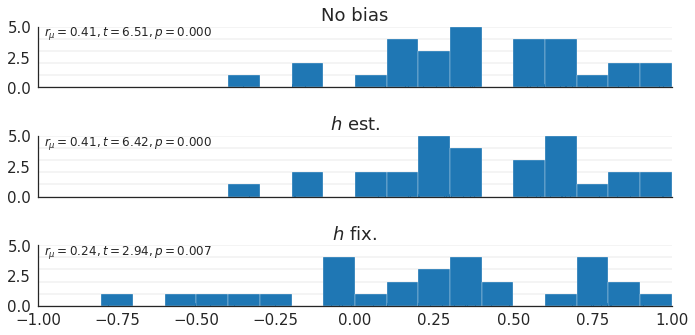

In [12]:
from scipy.stats import pearsonr, ttest_1samp

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(3,1,figsize=(10,5), sharex=True, sharey=True)
titles = [r'No bias', r'$h$ est.', r'$h$ fix.']

for ax, fit, title in zip(axes, [fit1, fit2, fit3], titles):
    
    ## Extract mood variables.
    M_obs = fit['M'].reshape(fit['N'], fit['B'] * 3)
    h_pred = np.median(fit['h_pred'], axis=0)
    M_pred = np.tanh(h_pred[...,[6,20,34]]).reshape(fit['N'], fit['B'] * 3)
    
    ## Iteratively compute Pearson correlation within subjects.
    r = [pearsonr(x, y)[0] for x, y in zip(M_obs, M_pred) if x.std()]
    t, p = ttest_1samp(r, 0)
        
    ## Plot.
    sns.distplot(r, bins=np.linspace(-1,1,21), kde=False, rug=True, 
                 hist_kws=dict(alpha=1, edgecolor='w'), ax=ax)
    ax.hlines(np.arange(6),-1,1,alpha=0.05, zorder=0)
    
    ## Add info.
    ax.annotate(r'$r_\mu=%0.2f, t=%0.2f, p=%0.3f$' %(np.mean(r), t, p), (0,0), (0.01,0.85),
                xycoords='axes fraction', fontsize=12)
    ax.set(xlim=(-1,1), ylim=(0,5), title=title)
    
sns.despine()
plt.tight_layout()

#### A good subject

![title](plots/subj_ppc/subj7.png)


#### A mediocre subject

![title](plots/subj_ppc/subj1.png)
